In [1]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
# Программу написал Куцевалов Данила Вячеславович ПМиИ Мех-мат 2021г

# установка в одну команду:
# pip install notebook pandas numpy scipy

# запуск:
# jupyter notebook

In [2]:
# 8 вариант
x_i = [0.24, 0.28, 0.32, 0.36, 0.40, 0.44]
n_i = [5, 8, 22, 9, 6]


gamma1 = 0.95
gamma2 = 0.99
alpha = 0.05 # Порядок значимости

n = np.sum(n_i)
k = 2 # Кол-во оцениваемых параметров это x_i и n_i (степень свободы)
m = len(n_i) # Кол-во значений параметров

i = range(1, m+1)

print('n:', n)

n: 50


In [3]:
data = pd.DataFrame(columns=['n_i', 'x_i'], index=i, data=zip(n_i, x_i[:-1]))
data['x_i+1']= data['x_i'].shift(-1).fillna(x_i[-1])

# Центры между точками x_i
data['x_i_sub'] = (data['x_i+1'] - data['x_i']) / 2 + data['x_i']
# x с чертой
x_ = np.sum(data['n_i'] * data['x_i_sub']) / n


S2 = np.sum(data['n_i'] * np.power(data['x_i_sub'], 2)) / n - np.power(x_, 2)
S = np.sqrt(S2)
sig2 = S2 * n / (n-1)
sig = np.sqrt(sig2)

print('X с чертой:', x_)
print('S^2:', S2, '   S:', S)
print('sigma^2:', sig2, '   sigma:', sig)

X с чертой: 0.34240000000000004
S^2: 0.001946239999999988    S: 0.04411621017267902
sigma^2: 0.0019859591836734573    sigma: 0.04456410196193184


In [4]:
# Доверительный интервал
def confidence_interval(t_gamma):
    r_part = t_gamma * sig / np.sqrt(n)
    return (x_ - r_part, x_ + r_part)

# Найти эту формулу стоило немало усилий T_T
t_gamma1 = stats.t.ppf((1 + gamma1)/2, n-1) # t(gamma, n)
t_gamma2 = stats.t.ppf((1 + gamma2)/2, n-1) # t(gamma, n)
print('При t({gamma}, {n})={t} : [{}; {}]'.format(gamma=gamma1,n=n, t=t_gamma1, *confidence_interval(t_gamma1)))
print('При t({gamma}, {n})={t} : [{}; {}]'.format(gamma=gamma2,n=n, t=t_gamma2, *confidence_interval(t_gamma2)))

При t(0.95, 50)=2.009575234489209 : [0.3297350223710662; 0.35506497762893385]
При t(0.99, 50)=2.67995197363155 : [0.3255100964969407; 0.3592899035030594]


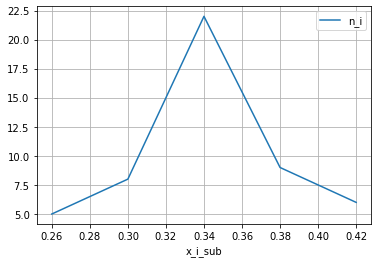

In [5]:
data.loc[: , ['x_i_sub', 'n_i']].set_index('x_i_sub').plot(grid=True)
data = data.drop(columns='x_i_sub')

In [6]:
z_i = lambda x: (x - x_)/sig

data['z_i'] = z_i(data['x_i'])
data.at[1, 'z_i'] = -np.infty
data['z_i+1'] = data['z_i'].shift(-1).fillna(+np.infty)

In [7]:
def fhi(x):
    sign = -1 if x < 0 else 1

    if np.isinf(x):
        return sign * 0.5

    def f(t):
        return np.exp(-(t*t)/2)
    value = 1/(np.sqrt(2*np.pi)) * integrate.quad(f, 0, abs(x))[0]

    return sign * value

In [8]:
data['fhi(z_i)'] = np.array(map(lambda x: fhi(x[1]), data['z_i'].iteritems()))
data['fhi(z_i+1)'] = data['fhi(z_i)'].shift(-1).fillna(0.5)
data['p_i'] = data['fhi(z_i+1)'] - data['fhi(z_i)']

data['n\'_i'] = data['p_i'] * n
data['(n_i - n\'_i)^2 / n\'_i'] = np.power(data['n_i'] - data['n\'_i'], 2) / data['n\'_i']

data['F_n'] = data['n_i'].cumsum() / n
data['F_o'] = data['p_i'].cumsum()
data['|F_n - F_o|'] = np.abs(data['F_n'] - data['F_o'])


In [9]:
X2_nablud = np.sum(data['(n_i - n\'_i)^2 / n\'_i'])
print('X^2 наблюдаемое:', X2_nablud)

D_nablud = np.max(data['|F_n - F_o|'])
print('D наблюдаемое:', D_nablud)

X^2 наблюдаемое: 3.67993765549942
D наблюдаемое: 0.047606335247313725


In [10]:
# Округляем до 4 знаков после запятой
data.astype(float).round(4) # если не привести к типу float, то округление не сработает


,n_i,x_i,x_i+1,z_i,z_i+1,fhi(z_i),fhi(z_i+1),p_i,n'_i,(n_i - n'_i)^2 / n'_i,F_n,F_o,|F_n - F_o|
1,5.0,0.24,0.28,-inf,-1.4002,-0.5000,-0.4193,0.0807,4.0361,0.2302,0.10,0.0807,0.0193
2,8.0,0.28,0.32,-1.4002,-0.5026,-0.4193,-0.1924,0.2269,11.3442,0.9859,0.26,0.3076,0.0476
3,22.0,0.32,0.36,-0.5026,0.3949,-0.1924,0.1536,0.3459,17.2974,1.2785,0.70,0.6536,0.0464
4,9.0,0.36,0.40,0.3949,1.2925,0.1536,0.4019,0.2484,12.4178,0.9407,0.88,0.9019,0.0219
5,6.0,0.40,0.44,1.2925,inf,0.4019,0.5000,0.0981,4.9044,0.2447,1.00,1.0000,0.0000
